In [1]:
!pip install supervision
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [9]:
import torch
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import supervision as sv
from peft import PeftModel
from transformers import AutoProcessor, AutoModelForCausalLM
import torch
import requests
import copy
%matplotlib inline
from typing import List, Dict, Any, Tuple
from torch.utils.data import Dataset, DataLoader
import json
from tqdm import tqdm  # Progress bar

In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Npr82rgYiQ5A5trJBlb8")
project = rf.workspace("capstone2025-mifho").project("military-base-object-detection")
version = project.version(12)
dataset = version.download("florence2-od")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Military-Base-Object-Detection-12 in florence2-od:: 100%|██████████| 12713/12713 [00:09<00:00, 1345.36it/s]


In [4]:
yolov12_model = version.model

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# @title Define `DetectionsDataset` class
class JSONLDataset:
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self) -> List[Dict[str, Any]]:
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Any]]:
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        try:
            image = Image.open(image_path)
            return (image, entry)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {image_path} not found.")


class DetectionDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        prefix = data['prefix']
        suffix = data['suffix']
        return prefix, suffix, image

In [7]:
val_dataset = DetectionDataset(
    jsonl_file_path = f"{dataset.location}/valid/annotations.jsonl",
    image_directory_path = f"{dataset.location}/valid/"
)
test_dataset = DetectionDataset(
    jsonl_file_path = f"{dataset.location}/test/annotations.jsonl",
    image_directory_path = f"{dataset.location}/test/"
)

In [10]:
# @title Collect predictions

PATTERN = r'([A-Za-z]+(-[A-Za-z]+)*)<loc_\d+>'

def extract_classes(dataset: DetectionDataset):
    class_set = set()
    for i in range(len(dataset.dataset)):
        image, data = dataset.dataset[i]
        suffix = data["suffix"]
        classes = re.findall(PATTERN, suffix)
        # print(classes)
        class_set.update(classes)
    return sorted(class_set)

CLASSES = extract_classes(test_dataset)

In [11]:
CLASSES = [cls[0] for cls in CLASSES]

In [12]:
print(CLASSES)

['Aircraft', 'Camouflage', 'Drone', 'Fire', 'Grenade', 'Hand-Gun', 'Knife', 'Military-Vehicle', 'Missile', 'Pistol', 'Rifle', 'Smoke', 'Soldier']


In [13]:
# Checkpoint and model configuration for target florence model
CHECKPOINT = "microsoft/Florence-2-base-ft"
REVISION = 'refs/pr/6'

# Load processor
processor = AutoProcessor.from_pretrained(
    CHECKPOINT,
    trust_remote_code=True,
    revision=REVISION
)


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [32]:
MAX_IMAGE_SIZE = (1024, 1024)  # Resize to a reasonable limit

targets = []
predictions = []

# Iterate over the dataset with a progress bar
for i in tqdm(range(len(val_dataset.dataset)), desc="Evaluating Model wit Validation Dataset", unit="image"):
    try:
        # Load image and ground truth
        image, data = val_dataset.dataset[i]
        prefix = data['prefix']
        suffix = data['suffix']  # Ground truth annotation

        # Resize image before saving
        image = image.convert("RGB")  # Ensure it's in RGB format
        image.thumbnail(MAX_IMAGE_SIZE)  # Resize while maintaining aspect ratio

        # Convert image to OpenCV format and save temporarily
        image_path = f"temp_image_{i}.jpg"
        image.save(image_path, "JPEG", quality=85)  # Save with compression

        # Run inference using the Roboflow model
        result = yolov12_model.predict(image_path, confidence=40, overlap=30).json()
        # print(result)  # Debugging output to check JSON response

        # Extract bounding boxes and classes
        if "predictions" in result and result["predictions"]:
            bboxes = []
            confidences = []
            class_ids = []

            for item in result["predictions"]:
                # Convert (cx, cy, w, h) to (xmin, ymin, xmax, ymax)
                xmin = item["x"] - item["width"] / 2
                ymin = item["y"] - item["height"] / 2
                xmax = item["x"] + item["width"] / 2
                ymax = item["y"] + item["height"] / 2
                class_name = item["class"]

                if class_name in CLASSES:
                    bboxes.append([xmin, ymin, xmax, ymax])
                    confidences.append(item["confidence"])
                    class_ids.append(CLASSES.index(class_name))

            # Convert to supervision Detections format
            if bboxes:
                prediction = sv.Detections(
                    xyxy=np.array(bboxes),
                    confidence=np.array(confidences),
                    class_id=np.array(class_ids)
                )
            else:
                prediction = sv.Detections.empty()  # No detections

        else:
            prediction = sv.Detections.empty()  # No predictions
        # print(prediction)

        # Convert ground truth annotations (suffix) to supervision format (if available)
        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
        target = processor.post_process_generation(suffix, task='<OD>', image_size=image.size)
        target = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, target, resolution_wh=image.size)
        target.class_id = np.array([CLASSES.index(class_name) for class_name in target['class_name']])
        # print(target)

        targets.append(target)
        predictions.append(prediction)

    except Exception as e:
        print(f"Error processing index {i}: {e}")

# Print summary
print(f"\nProcessed {len(targets)} samples successfully.")


Evaluating Model wit Validation Dataset: 100%|██████████| 2799/2799 [37:42<00:00,  1.24image/s]


Processed 2799 samples successfully.


In [34]:
# @title Calculate mAP of Validation Dataset
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.5f}")
print(f"map50: {mean_average_precision.map50:.5f}")
print(f"map75: {mean_average_precision.map75:.5f}")

map50_95: 0.34526
map50: 0.53119
map75: 0.35205


In [35]:
def calculate_per_class_map50(predictions, targets, classes):
    per_class_map50 = {}

    for class_idx, class_name in enumerate(classes):
        class_preds = []
        class_targets = []

        for pred, tgt in zip(predictions, targets):
            pred_mask = pred.class_id == class_idx
            tgt_mask = tgt.class_id == class_idx

            class_preds.append(pred[pred_mask])
            class_targets.append(tgt[tgt_mask])

        # Compute mAP only at IoU 0.5
        class_map = sv.MeanAveragePrecision.from_detections(
            predictions=class_preds,
            targets=class_targets
        )

        per_class_map50[class_name] = class_map.map50

    return per_class_map50


In [37]:
per_class_map50 = calculate_per_class_map50(predictions, targets, CLASSES)

print("\n--- Per-Class mAP@50 ---")
for class_name, map50 in per_class_map50.items():
    print(f"Class: {class_name:15s} | mAP@50: {map50:.5f}")


--- Per-Class mAP@50 ---
Class: Aircraft        | mAP@50: 0.76216
Class: Camouflage      | mAP@50: 0.00000
Class: Drone           | mAP@50: 0.00000
Class: Fire            | mAP@50: 0.32526
Class: Grenade         | mAP@50: 0.00000
Class: Hand-Gun        | mAP@50: 0.99500
Class: Knife           | mAP@50: 0.00000
Class: Military-Vehicle | mAP@50: 0.48516
Class: Missile         | mAP@50: 0.43589
Class: Pistol          | mAP@50: 0.00000
Class: Rifle           | mAP@50: 0.00000
Class: Smoke           | mAP@50: 0.21563
Class: Soldier         | mAP@50: 0.00000


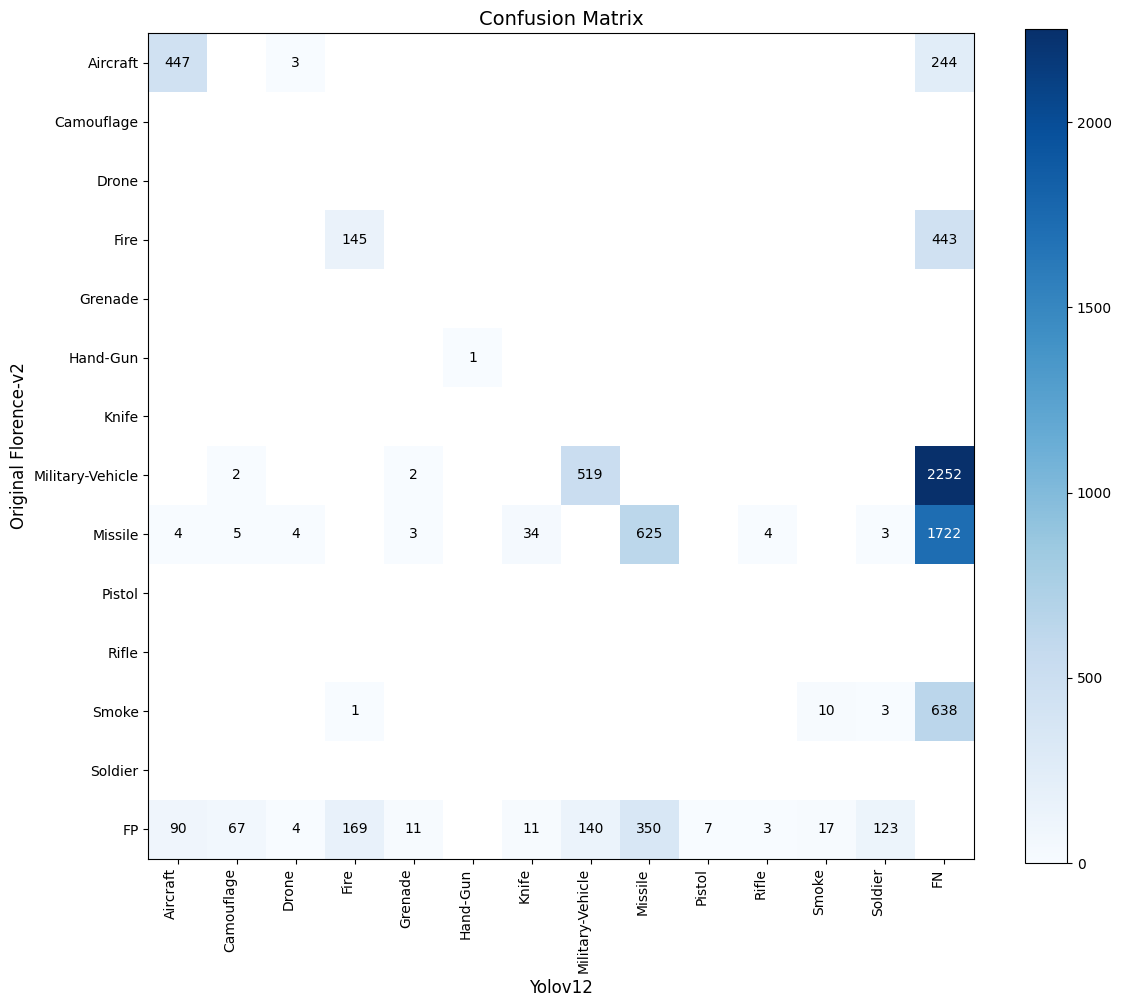

In [16]:
import matplotlib.pyplot as plt

# Compute Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

# Plot the Confusion Matrix
fig = confusion_matrix.plot()  # This creates and returns a Matplotlib figure

# Get the current axis and set labels
ax = plt.gca()  # Get the current axis
ax.set_xlabel("Yolov12", fontsize=12)
ax.set_ylabel("Original Florence-v2", fontsize=12)
ax.set_title("Confusion Matrix", fontsize=14)

# Show the plot
plt.show()

In [31]:
import time

MAX_IMAGE_SIZE = (1024, 1024)  # Resize to a reasonable limit

targets = []
predictions = []
inference_times = []  # To store inference durations

# Iterate over the dataset with a progress bar
for i in tqdm(range(len(test_dataset.dataset)), desc="Evaluating Model with Test Dataset", unit="image"):
    try:
        # Load image and ground truth
        image, data = test_dataset.dataset[i]
        prefix = data['prefix']
        suffix = data['suffix']  # Ground truth annotation

        # Resize image before saving
        image = image.convert("RGB")
        image.thumbnail(MAX_IMAGE_SIZE)

        image_path = f"temp_image_{i}.jpg"
        image.save(image_path, "JPEG", quality=85)

        # ------------------ TIMING START ------------------
        start_time = time.time()
        result = yolov12_model.predict(image_path, confidence=40, overlap=30).json()
        end_time = time.time()
        # ------------------- TIMING END -------------------

        inference_times.append(end_time - start_time)

        # Extract bounding boxes and classes
        if "predictions" in result and result["predictions"]:
            bboxes = []
            confidences = []
            class_ids = []

            for item in result["predictions"]:
                xmin = item["x"] - item["width"] / 2
                ymin = item["y"] - item["height"] / 2
                xmax = item["x"] + item["width"] / 2
                ymax = item["y"] + item["height"] / 2
                class_name = item["class"]

                if class_name in CLASSES:
                    bboxes.append([xmin, ymin, xmax, ymax])
                    confidences.append(item["confidence"])
                    class_ids.append(CLASSES.index(class_name))

            if bboxes:
                prediction = sv.Detections(
                    xyxy=np.array(bboxes),
                    confidence=np.array(confidences),
                    class_id=np.array(class_ids)
                )
            else:
                prediction = sv.Detections.empty()

        else:
            prediction = sv.Detections.empty()

        # Convert ground truth to supervision format
        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
        target = processor.post_process_generation(suffix, task='<OD>', image_size=image.size)
        target = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, target, resolution_wh=image.size)
        target.class_id = np.array([CLASSES.index(class_name) for class_name in target['class_name']])

        targets.append(target)
        predictions.append(prediction)

    except Exception as e:
        print(f"Error processing index {i}: {e}")

# Summary
print(f"\nProcessed {len(targets)} samples successfully.")

# Inference time statistics
total_time = sum(inference_times)
average_time = total_time / len(inference_times)
fps = 1 / average_time

print(f"\n--- Inference Timing ---")
print(f"Total inference time: {total_time:.2f} seconds")
print(f"Average inference time per image: {average_time:.4f} seconds")
print(f"Frames Per Second (FPS): {fps:.2f}")


Evaluating Model with Test Dataset: 100%|██████████| 154/154 [02:20<00:00,  1.09image/s]


Processed 154 samples successfully.

--- Inference Timing ---
Total inference time: 131.77 seconds
Average inference time per image: 0.8557 seconds
Frames Per Second (FPS): 1.17


In [19]:
# @title Calculate mAP of Test Dataset
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.5f}")
print(f"map50: {mean_average_precision.map50:.5f}")
print(f"map75: {mean_average_precision.map75:.5f}")

map50_95: 0.60845
map50: 0.78666
map75: 0.66625


In [21]:
def calculate_per_class_map(predictions, targets, classes, iou_thresholds=[0.5, 0.75]):
    per_class_metrics = {}

    for class_idx, class_name in enumerate(classes):
        class_preds = []
        class_targets = []

        for pred, tgt in zip(predictions, targets):
            pred_mask = pred.class_id == class_idx
            tgt_mask = tgt.class_id == class_idx

            class_preds.append(pred[pred_mask])
            class_targets.append(tgt[tgt_mask])

        class_map = sv.MeanAveragePrecision.from_detections(
            predictions=class_preds,
            targets=class_targets,
        )

        per_class_metrics[class_name] = {
            'mAP@50': class_map.map50,
            'mAP@75': class_map.map75,
            'mAP@50:95': class_map.map50_95
        }

    return per_class_metrics


In [22]:
per_class_results = calculate_per_class_map(predictions, targets, CLASSES)

print(f"\n--- Per-Class mAP Scores ---")
for class_name, scores in per_class_results.items():
    print(f"Class: {class_name:15s} | mAP@50: {scores['mAP@50']:.4f} | "
          f"mAP@75: {scores['mAP@75']:.4f} | mAP@50:95: {scores['mAP@50:95']:.4f}")



--- Per-Class mAP Scores ---
Class: Aircraft        | mAP@50: 0.9950 | mAP@75: 0.8807 | mAP@50:95: 0.6691
Class: Camouflage      | mAP@50: 0.9511 | mAP@75: 0.8541 | mAP@50:95: 0.7581
Class: Drone           | mAP@50: 0.9735 | mAP@75: 0.7677 | mAP@50:95: 0.7143
Class: Fire            | mAP@50: 0.3150 | mAP@75: 0.0000 | mAP@50:95: 0.0941
Class: Grenade         | mAP@50: 0.9950 | mAP@75: 0.9950 | mAP@50:95: 0.9567
Class: Hand-Gun        | mAP@50: 0.8636 | mAP@75: 0.8636 | mAP@50:95: 0.7429
Class: Knife           | mAP@50: 0.9210 | mAP@75: 0.9210 | mAP@50:95: 0.8565
Class: Military-Vehicle | mAP@50: 0.8809 | mAP@75: 0.5069 | mAP@50:95: 0.5321
Class: Missile         | mAP@50: 0.5951 | mAP@75: 0.2664 | mAP@50:95: 0.3527
Class: Pistol          | mAP@50: 0.9564 | mAP@75: 0.9564 | mAP@50:95: 0.9031
Class: Rifle           | mAP@50: 0.7916 | mAP@75: 0.7916 | mAP@50:95: 0.7218
Class: Smoke           | mAP@50: 0.5062 | mAP@75: 0.5062 | mAP@50:95: 0.3037
Class: Soldier         | mAP@50: 0.8231 | mAP

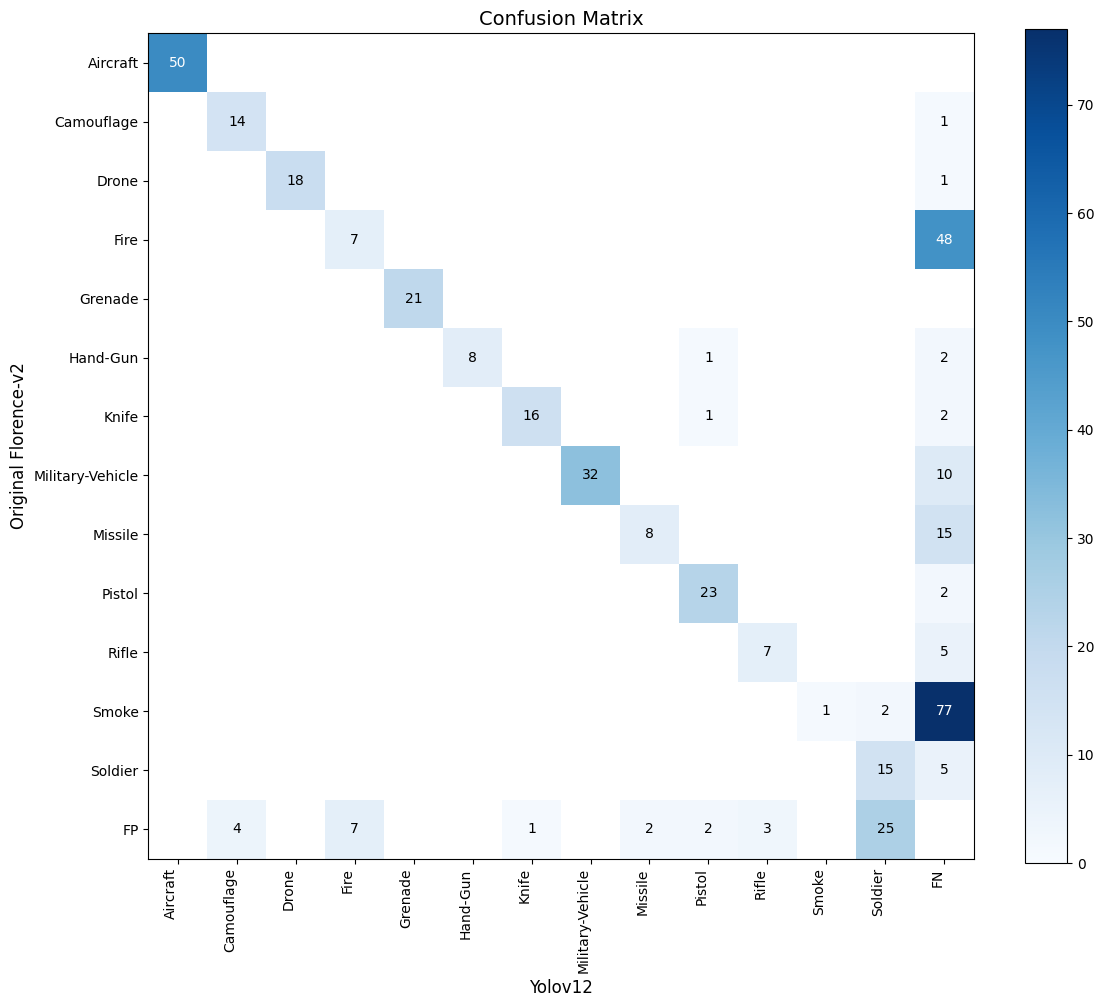

In [23]:
import matplotlib.pyplot as plt

# Compute Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

# Plot the Confusion Matrix
fig = confusion_matrix.plot()  # This creates and returns a Matplotlib figure

# Get the current axis and set labels
ax = plt.gca()  # Get the current axis
ax.set_xlabel("Yolov12", fontsize=12)
ax.set_ylabel("Original Florence-v2", fontsize=12)
ax.set_title("Confusion Matrix", fontsize=14)

# Show the plot
plt.show()

In [24]:
import numpy as np
import pandas as pd

# Function to calculate per-class accuracy
def per_class_accuracy(targets, predictions, class_names):
    class_wise_results = {}

    for class_id, class_name in enumerate(class_names):
        # Get all ground truth instances of the class
        total_targets = sum(class_id in t.class_id for t in targets)

        # Get all correctly predicted instances of the class
        correct_predictions = sum(
            class_id in t.class_id and class_id in p.class_id
            for t, p in zip(targets, predictions)
        )

        # Calculate accuracy
        accuracy = (correct_predictions / total_targets) if total_targets > 0 else 0.0
        class_wise_results[class_name] = round(accuracy * 100, 2)  # Convert to percentage

    return class_wise_results

# Generate accuracy table
accuracy_results = per_class_accuracy(targets, predictions, CLASSES)

# Convert to DataFrame for better readability
accuracy_df = pd.DataFrame(list(accuracy_results.items()), columns=["Class", "Accuracy (%)"])

# Calculate average accuracy
avg_accuracy = accuracy_df["Accuracy (%)"].mean()

# Display accuracy table
print(accuracy_df)
print(f"\n\033[1mAverage Accuracy: {avg_accuracy:.2f}%\033[0m")

               Class  Accuracy (%)
0           Aircraft        100.00
1         Camouflage        100.00
2              Drone        100.00
3               Fire         40.00
4            Grenade        100.00
5           Hand-Gun         80.00
6              Knife        100.00
7   Military-Vehicle        100.00
8            Missile         61.54
9             Pistol        100.00
10             Rifle         54.55
11             Smoke          2.63
12           Soldier         85.71

Average Accuracy: 78.80%


In [25]:
# @title Classification Report

import pandas as pd
from sklearn.metrics import classification_report

def classification_report_table(targets, predictions):
    report = classification_report(targets, predictions, target_names=CLASSES, output_dict=True)
    df = pd.DataFrame(report).transpose()

    print("\nClassification Report Table:")
    print(df)

    return df  # If you want to save or use it further

In [26]:
# Ensure predictions and targets only contain class IDs
processed_targets = []
processed_predictions = []

for pred in predictions:
    if isinstance(pred, sv.Detections):
        pred_class_ids = pred.class_id.tolist()
        if pred_class_ids:
            processed_predictions.append(pred_class_ids[0])  # Take the first class ID
    else:
        processed_predictions.append(pred)

for target in targets:
    if isinstance(target, sv.Detections):
        target_class_ids = target.class_id.tolist()
        if target_class_ids:
            processed_targets.append(target_class_ids[0])  # Take the first class ID
    else:
        processed_targets.append(target)


In [27]:
# Ensure both lists have the same length
min_length = min(len(processed_targets), len(processed_predictions))
processed_targets = processed_targets[:min_length]  # Trim extra elements
processed_predictions = processed_predictions[:min_length]  # Trim extra elements


In [28]:
from sklearn.metrics import classification_report

# Ensure unique class labels are correctly assigned
unique_classes = sorted(set(processed_targets) | set(processed_predictions))  # Get all unique class IDs
filtered_target_names = [CLASSES[i] for i in unique_classes]  # Ensure correct mapping

# Generate classification report with zero_division handling
report = classification_report(
    processed_targets,
    processed_predictions,
    target_names=filtered_target_names,
    zero_division=0  # Avoid undefined values
)

# Print the classification report in bold
print("\033[1mClassification Report:\n\033[0m", report)


Classification Report:
                   precision    recall  f1-score   support

        Aircraft       0.15      0.17      0.16        12
      Camouflage       0.17      0.25      0.20        12
           Drone       0.00      0.00      0.00        10
            Fire       0.11      0.07      0.08        15
         Grenade       0.11      0.12      0.12         8
        Hand-Gun       0.25      0.20      0.22        10
           Knife       0.00      0.00      0.00         2
Military-Vehicle       0.17      0.20      0.18        10
         Missile       0.25      0.18      0.21        11
          Pistol       0.10      0.25      0.14         4
           Rifle       0.44      0.44      0.44         9
           Smoke       0.00      0.00      0.00        22
         Soldier       0.00      0.00      0.00         3

        accuracy                           0.14       128
       macro avg       0.13      0.14      0.14       128
    weighted avg       0.14      0.14      0.1

In [39]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [44]:
from ultralytics import YOLO

# Load local YOLOv12 model
model = YOLO('/content/yolov12n.pt')  # or yolov12s.pt, yolov12m.pt, etc.

# Count parameters
def count_model_parameters(model):
    total_params = sum(p.numel() for p in model.model.parameters())
    trainable_params = sum(p.numel() for p in model.model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    return total_params, trainable_params

count_model_parameters(model)


Total parameters: 2,553,904
Trainable parameters: 0


(2553904, 0)